In [1]:
#### rewriting scripts to calculate neuronal activity at start of interaction
#### need to divide neurons into relevant categories (unimodal and multimodal)
### add option to run specific neurons (i.e. LA, BLA or BMA)

import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib.gridspec as gridspec
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats

import import_ipynb
import func_format
import func_analysis

importing Jupyter notebook from func_format.ipynb
importing Jupyter notebook from func_analysis.ipynb


In [2]:
def extractusableint(modality, intcat, foldername, presentationnumber):
    if modality == 'female':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Female']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Female']
    elif modality == 'male':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
    elif modality == 'object':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
    elif modality == 'food':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Food']
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Food']
    elif modality == 'social':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Male']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Female'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Male']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Female'])
    elif modality == 'nonsocial':
        usableint = np.ravel(foldername)[np.ravel(intcat) == 'Object']
        usableint = np.append(usableint, np.ravel(foldername)[np.ravel(intcat) == 'Food'])
        usablepresentationnumber = np.ravel(presentationnumber)[np.ravel(intcat) == 'Object']
        usablepresentationnumber = np.append(usablepresentationnumber, np.ravel(presentationnumber)[np.ravel(intcat) == 'Food'])
    elif modality == 'panresponsive':
        usableint = foldername
        usablepresentationnumber = presentationnumber
    else:
        usableint = foldername
        usablepresentationnumber = presentationnumber
    
    return(usableint, usablepresentationnumber)

def order_pad_mask(spiketrain):

    lengths = []
    for i, fr in enumerate(spiketrain):
        fr = np.ravel(np.array(fr, np.float32))
        lengths = np.append(lengths, len(fr))

    maxlength = np.int(np.max(lengths))
    heatmaparray = np.zeros((len(spiketrain), maxlength))
    sortorder = np.argsort(lengths)
    
    for i, row in enumerate(np.argsort(lengths)):
        fr = np.ravel(np.array(spiketrain[row], np.float32))
        if len(fr) == np.int(np.max(lengths)):
            heatmaparray[i] = fr
        else:
            halfsizedifference = np.int(np.ceil((maxlength - lengths[row])/2))
            fr_padded = np.hstack((np.zeros(halfsizedifference+1), fr[1:-1], np.zeros(halfsizedifference+1)))
            if len(heatmaparray[i]) != len(fr_padded):
                fr_padded = fr_padded[:len(heatmaparray[i])]
            heatmaparray[i] = fr_padded
        
    heatmap_masked = np.ma.masked_where(heatmaparray == 0, heatmaparray)
    
    return(heatmap_masked, sortorder)

def plot_heatmap_rawvalues(heatmap_masked, color, vmin, vmax):
    
    fig, ax = plt.subplots(1, figsize = (10, 8))

    a = ax.imshow(heatmap_masked, aspect = 'auto', vmin = vmin, vmax = vmax, cmap = color, interpolation = None)
    #plt.ylim(600, 800)
    ax.grid(False)
    #ax.set_xlim(1200, 2200)
    #ax.set_xticks(np.arange(200, 1501, 100))
    #ax.set_xticklabels((np.linspace(0, 10*13, 14)))
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_facecolor('white')
    #plt.colorbar(a)
    
    return(fig)

def plot_sorted_timewarp(timewarp, vmin, vmax, color):
    sortorder = np.reshape(np.argsort(np.mean(timewarp[:,250:], axis = 1)), (len(timewarp), 1))

    timewarp_sorted = np.take_along_axis(timewarp, sortorder, axis = 0)
    
    plt.close()
    
    fig, ax = plt.subplots(1, figsize = (4, 4))
    a = ax.imshow(timewarp_sorted, vmin = vmin, vmax = vmax, cmap = color, aspect = 'auto')
    ax.set_ylim(0, len(timewarp_sorted))
    ax.vlines(99, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
    ax.vlines(149, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
    ax.vlines(349, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'k', alpha = 0.75, lw = 1)
    
    ax.set_xticks((0, 99, 149, 349, 448))
    ax.set_xticklabels(('10s before \nplacement', 'stimulus \nplacement start', 'stimulus \nplacement end', 'stimulus contact', '10s after contact'), rotation = 90, fontsize = 8)
    plt.colorbar(a)
    ax.grid(False)
    ax.set_yticks([])
    plt.tight_layout()
    return(fig)

def plot_populationtimewarp(timewarpresults):
    
    timewarpresults[np.isinf(timewarpresults)] = 0
    timewarpresults[np.isnan(timewarpresults)] = 0
    timewarpresults[timewarpresults > 20] = 20
    
    plt.close()
    fig, ax = plt.subplots(1, figsize = (4, 4))

    timewarpmean = np.mean(timewarpresults[1:, :-1], axis = 0)
    timewarpsem = stats.sem(timewarpresults[1:, :-1], axis = 0)

    ax.fill_between(np.arange(0, len(timewarpmean)), timewarpmean+timewarpsem, timewarpmean-timewarpsem, color = 'lightcoral', alpha = 0.5)
    ax.plot(timewarpmean, color = 'firebrick', lw = 1)

    ax.grid(False)
    ax.set_ylabel('Z Score')
    ax.vlines(99, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.vlines(149, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.vlines(349, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.set_xticks((0, 99, 149, 349, 448))
    ax.set_xticklabels(('10s before \nplacement', 'placement start', 'placement end', 'stimulus contact', '10s after contact'), 
            rotation = 90, fontsize = 8)
    ax.set_ylim(-.2,3)
    ax.set_xlim(0, 448)
    plt.tight_layout()
    return(fig, timewarpmean, timewarpsem)

def calculate_zscore(neuron, start, stop, basestart, basestop, binsize):
    spikes = func_analysis.extractSpikes(neuron, start, stop)
    fr = func_analysis.firingrate(spikes, binsize, start, stop, smooth=True, smoothkernel = 1)
    bins = np.arange(start, stop, binsize)
    
    baselinespikes = func_analysis.extractSpikes(neuron, basestart, basestop)
    baselinefr = func_analysis.firingrate(baselinespikes, binsize, basestart, basestop, smooth=True, smoothkernel = 1)
    meanbaseline = np.mean(baselinefr)
    stdbaseline = np.std(baselinefr)
    
    zscore_fr = (fr-meanbaseline)/stdbaseline
    zscorebaseline = (baselinefr-meanbaseline)/stdbaseline
    return(zscore_fr, bins, np.mean(zscorebaseline[-30:]))

def timewarp_interpolate(x, binnum):
    f_x = InterpolatedUnivariateSpline(np.arange(0, len(x)), x)
    newbins = np.linspace(0, len(x), binnum)
    x_interp = f_x(newbins)
    
    return(x_interp)

In [13]:
##### looks at z-scored firing activity at the beginning of the interaction, specifically comparing placement of the stimulus and active engagement with the stimulus

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

savepath = 'F:/BLAClustering_baseall/'
func_format.foldercheck(savepath)

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(449)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
#neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/BLAClustering_baseall/BLA_responsetype_day1_baseall.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluesave = np.zeros(5)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] == 'NoResponses' or row[3] == 'Inhibition':
        continue
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


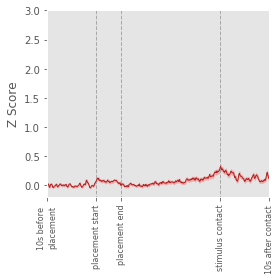

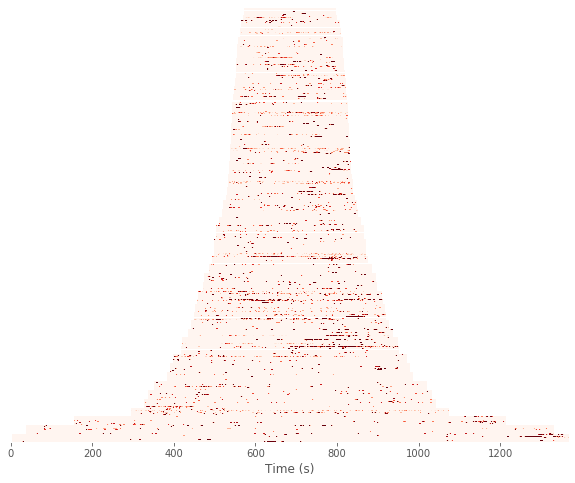

In [14]:
savepath = 'F:/AgglomerativeClusteringPlots//'
func_format.foldercheck(savepath)

fig1 = plot_sorted_timewarp(timewarpresults, 0, 5, 'Reds')
fig1.savefig(savepath+'nonresponsive_fig1.png', dpi = 300)
#fig1.show()
#plt.rcParams['svg.fonttype'] = 'none'
#fig1.savefig(savepath+'allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)
#fig1.savefig(savepath+'BLAresponsive_graph2.png', dpi = 300)
[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'nonresponsive_fig2.png', dpi = 300)
#fig2.savefig(savepath+'BLAresponsive_graph3.png', dpi = 300)
[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
fig3 = plot_heatmap_rawvalues(heatmap_masked, 'Reds', 0, 5)
fig3.savefig(savepath+'nonresponsive_fig3.png', dpi = 300)
#plt.rcParams['svg.fonttype'] = 'none'
#fig3.savefig(savepath+'allneuronsraw.svg', format = 'svg', dpi = 300, transparent = True)
#fig3.show()
#fig3.savefig(savepath+'BLAresponsive_graph1.png', dpi = 300)

np.savetxt(savepath+'nonresponsive_text1.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath+'nonresponsive_text2.csv', rawvaluesave, delimiter = ',', fmt = '%s')

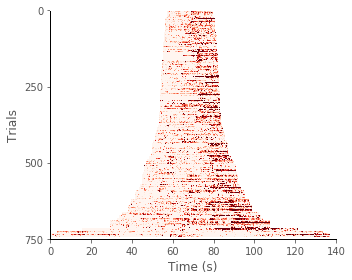

In [44]:
fig, ax = plt.subplots(1, figsize = (5, 4))

ax.imshow(heatmap_masked, aspect = 'auto', vmin = 0, vmax = 5, cmap = 'Reds')
ax.set_ylim(len(heatmap_masked), 0)
ax.set_facecolor('white')
ax.set_yticks((0, 250, 500, 750))
ax.set_ylabel('Trials')
ax.set_xticks((0,200,400,600,800,1000,1200, 1400))
ax.set_xticklabels((0,20,40,60,80,100,120,140))
ax.set_xlabel('Time (s)')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.grid(False)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3/allneuronsraw.svg', format = 'svg', dpi = 300, transparent = True)

In [55]:
sortedheatmap = np.take_along_axis(timewarpresults[1:], sortorder.reshape(-1,1), axis = 0)

In [77]:
len(sortedheatmap[0])-100

349

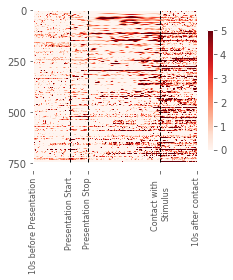

In [84]:
fig, ax = plt.subplots(1, figsize = (3.5,4))
a = ax.imshow(sortedheatmap, aspect = 'auto', vmin=0, vmax = 5, cmap = 'Reds')
ax.set_facecolor('white')
ax.grid(False)
plt.colorbar(a, shrink = 0.75)
ax.set_yticks((0, 250, 500, 750))
ax.set_xticks((0, 100, 150, len(sortedheatmap[0])-100, len(sortedheatmap[0])))
ax.set_xticklabels(('10s before Presentation', 'Presentation Start', 'Presentation Stop', 'Contact with \nStimulus', '10s after contact'), rotation = 90, fontsize = 8)
ax.vlines(100, ymin = 0, ymax = len(sortedheatmap), lw = 1, linestyle = '--', color = 'k')
ax.vlines(150, ymin = 0, ymax = len(sortedheatmap), lw = 1, linestyle = '--', color = 'k')
ax.vlines(len(sortedheatmap[0])-100, ymin = 0, ymax = len(sortedheatmap), lw = 1, linestyle = '--', color = 'k')
ax.set_xlim(0, len(sortedheatmap[0]))

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3/allneuronstimewarp.svg', format = 'svg', dpi = 300, transparent = True)

In [52]:
sortorder.reshape(-1,1).shape

(743, 1)

In [51]:
timewarpresults[1:].shape

(743, 449)

In [ ]:
intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]

passive = []
active = []

for j, row2 in enumerate(intvalues):
        
    syncpath = 'F:/'+row2[0]+'/Electrophys/'+row2[1]+'/Sync/'+row2[2]+'_frameSync.csv'
    sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
    #camsync = np.array(behavior[0, 1:], np.float)
    #velocity = np.array(behavior[2,1:], np.float)

    presentationstart = np.float32(sync[np.int(row2[3])])
    contactstart = np.float32(sync[np.int(row2[7])])
    presentationstop = np.float32(sync[np.int(row2[5])])
    if row2[6] != 'nan':
        active = np.append(active, contactstart-presentationstop)
    else:
        passive = np.append(passive, contactstart-presentationstop)

    ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
    #if (contactstart - presentationstop) < 5:
        #continue

In [ ]:
intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)[1:]
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
allsave = np.zeros(14)

for i, row in enumerate(intvalues):
    
    #if row[6] == 'nan':
        #continue
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    if i == 0:
        behavior = np.loadtxt('F:/'+row[0]+'/TrackingData/'+row[1]+'_rat1values.csv', delimiter = ',', dtype = str)
        behaviorsync = np.array(behavior[0][1:], float)
        tailvelocity = np.array(behavior[2][1:], float)
    elif row[1] != intvalues[i-1][1]:
        behavior = np.loadtxt('F:/'+row[0]+'/TrackingData/'+row[1]+'_rat1values.csv', delimiter = ',', dtype = str)
        behaviorsync = np.array(behavior[0][1:], float)
        tailvelocity = np.array(behavior[2][1:], float)
        
    syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row[2]+'_frameSync.csv'
    sync = np.loadtxt(syncpath, delimiter = ',', dtype = float)
    
    presentationstart = sync[np.int(row[3])]
    presentation = sync[np.int(row[4])]
    presentationstop = sync[np.int(row[5])]
    movementstart = sync[np.int(row[6])]
    contactstart = sync[np.int(row[7])]
    
    if contactstart-presentation < 1:
        continue
    
    contactsync = np.argmin(np.abs(behaviorsync - (contactstart+5)))
    contactmoment = np.argmin(np.abs(behaviorsync - contactstart))
    beforecontactsync = np.argmin(np.abs(behaviorsync - (contactstart-5)))
    
    segmentvelocity = tailvelocity[beforecontactsync:contactsync]
    contactindex = contactmoment - beforecontactsync
    
    peaks, _ = signal.find_peaks(segmentvelocity, height = 4, distance = 30)
    
    try:
        closestpeak = np.where(peaks <= contactindex)[0][-1]
    except:
        closestpeak = np.nan
        continue
        
    segmentopeak = np.flip(segmentvelocity[:peaks[closestpeak]])-2
    for j, ii in enumerate(segmentopeak[:-1]):
        if ii > 0 and segmentopeak[j+1] < 0:
            velocityrampupindex = j
            break
    start = peaks[closestpeak]-velocityrampupindex

    segmentfrompeak = segmentvelocity[peaks[closestpeak]:]-2
    for j, ii in enumerate(segmentfrompeak[:-1]):
        if ii > 0 and segmentfrompeak[j+1] < 0:
            velocityrampdownindex = j
            break
    stop = peaks[closestpeak]+velocityrampdownindex
      
    velocityboutstart = behaviorsync[start+beforecontactsync]
    velocityboutstop = behaviorsync[stop+beforecontactsync]
    
    rowsave = np.hstack((row, presentationstart, velocityboutstart, velocityboutstop))
    
    allsave = np.vstack((allsave, rowsave))

allsave = allsave[1:]

In [ ]:
samesort_timewarp = np.take_along_axis(timewarpresults[1:], np.reshape(sortorder, (len(sortorder), 1)), axis = 0)
plt.close()

vmin = 0
vmax = 7
color = 'Reds'
fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.imshow(samesort_timewarp, vmin = vmin, vmax = vmax, cmap = color, aspect = 'auto')
ax.set_ylim(len(samesort_timewarp), 0)
ax.vlines(99, ymin = 0, ymax = len(samesort_timewarp), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
ax.vlines(149, ymin = 0, ymax = len(samesort_timewarp), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
ax.vlines(349, ymin = 0, ymax = len(samesort_timewarp), linestyle = '--', color = 'k', alpha = 0.75, lw = 1)

ax.set_xticks((0, 99, 149, 349, 448))
ax.set_xticklabels(('10s before \nplacement', 'stimulus \nplacement start', 'stimulus \nplacement end', 'stimulus contact', '10s after contact'), rotation = 90, fontsize = 8)
plt.colorbar(a)
ax.grid(False)
ax.set_yticks([])
plt.tight_layout()
plt.savefig(savepath+'panresponsive_graph4.png', dpi = 300)

In [ ]:
#### timewarp entire interaction period (baseline, interaction, postbaseline) to compare aftereffects

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

savepath = 'F:/InteractionEnd_BLA_new/'
func_format.foldercheck(savepath)

zscoreresults = []
timewarpresults = np.zeros(899)
saveid = ['ratID', 'date', 'neuronname', 'neuroncat1', 'neuroncat2', 'intcat', 'inttype', 'intnumber', 'auroc']
intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
neuronprofile = np.loadtxt('F:/ResponseType_BLAday1_4rats/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]
### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response
rawvaluessave = ['Baseline Hz mean', 'Interaction Hz mean', 'Afterint Hz mean', 'Baseline Zscore mean', 'Interaction Zscore mean', 'Afterint Zscore mean']

for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    #if row[3] == 'Inhibition' or row[3] == 'NoResponses':
        #continue
    #if row[3] == 'Inhibition' or row[3] == 'NoResponses' or row[4] == 'male' or row[4] == 'food' or row[4] == 'object' or row[4] == 'nonsocial':
        #continue
        #row[4] = 'male'
    #if row[4] == 'social' or row[4] == 'panresponsive':
        #row[4] = 'female'
    
    if row[3] != 'multimodal':
        continue
    
    #usableint = np.ravel(foldername)
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:# and np.ravel(usablepresentationnumber)[np.ravel(usableint) == row2[2]][0] == 4:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            
            presentation = np.float32(sync[np.int(row2[4])])
            presentationstart = np.float32(sync[np.int(row2[3])])
            removal = np.float32(sync[np.int(row2[-2])])
            
            [zscore_fr, bins] = calculate_zscore(neuron, presentation-300, removal+300, 
                                         presentationstart-300, presentationstart-10, 1)
            zscoreresults.append([zscore_fr])
            
            #### timewarps data
            removalbin = np.argmin(np.abs(bins - removal))
            
            beforeinteractionfr = zscore_fr[:300]
            interactionfr = zscore_fr[300:removalbin]
            postinteractionfr = zscore_fr[removalbin:removalbin+299]
            
            #rawvalues = (np.mean(beforeinteractionfr), np.mean(interactionfr), np.mean(postinteractionfr), np.mean(postinteractionfr[:60]))
            #rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            
            interactionfr = timewarp_interpolate(interactionfr, 300)
            
            timewarp_fr = np.hstack((beforeinteractionfr, interactionfr, postinteractionfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))
            
            
            
            baselinespikes = func_analysis.extractSpikes(neuron, presentationstart-300, presentationstart-10)
            baselinefr = func_analysis.firingrate(neuron, 1, presentationstart-300, presentationstart-10, smooth=False)
            afterintspikes = func_analysis.extractSpikes(neuron, removal, removal+300)
            afterintfr = func_analysis.firingrate(neuron, 1, removal, removal+300, smooth=False)
            
            [auroc, fpr, tpr] = func_analysis.calcROC(baselinefr, afterintfr)
            idinfo = [row[0], row[1], row[2], row[3], row[4], intcat[j], inttype[j], row2[2], auroc]
            
            saveid = np.vstack((saveid, idinfo))
            
            baselinemeanhz = np.nanmean(baselinefr)
            intfr = func_analysis.firingrate(neuron, 1, presentationstart, removal, smooth=False)
            intmeanhz = np.nanmean(intfr)
            afterintmeanhz = np.nanmean(afterintfr)
            
            rawvalues = np.hstack((baselinemeanhz, intmeanhz, afterintmeanhz, np.mean(beforeinteractionfr), np.mean(interactionfr), np.mean(postinteractionfr)))
            rawvaluessave = np.vstack((rawvaluessave, rawvalues))
timewarpresults = timewarpresults[1:]

In [ ]:
allaftereffectscores = np.hstack((saveid, rawvaluessave))
np.savetxt(savepath+'aftereffects_femaleall.csv', allaftereffectscores, delimiter = ',', fmt = '%s')

In [ ]:

timewarpresults[timewarpresults > 20] = 20
timewarpresults[np.isinf(timewarpresults)] = 0
timewarpmean = np.nanmean(timewarpresults, axis = 0)
timewarpsem = stats.sem(timewarpresults, axis = 0, nan_policy = 'omit')

[heatmap_masked, sortorder_raw] = order_pad_mask(zscoreresults)
fig3 = plot_heatmap_rawvalues(heatmap_masked, 'Reds', 0, 7)

fig3.savefig(savepath+'femaleallBLA_graph1.png', dpi = 300)

plt.close()
fig2, ax = plt.subplots(1, figsize = (4, 3))
ax.fill_between(np.arange(0, len(timewarpmean)), timewarpmean+timewarpsem, timewarpmean-timewarpsem, color = 'lightcoral', alpha = 0.5)
ax.plot(timewarpmean, color = 'firebrick', lw = 1)
ax.set_xticks((0, 300, 600, 899))
ax.grid(False)
ax.vlines(300, -.5, 8, linestyle = '--', color = 'darkgrey', lw = 1)
ax.vlines(600, -.5, 8, linestyle = '--', color = 'darkgrey', lw = 1)
ax.set_ylim (-.5, 8)
ax.set_xlim(0, 899)
ax.set_xticklabels((' ', 'Stimulus \nPresentation', 'Stimulus \nRemoval', ' '), rotation = 90, fontsize = 8)
plt.tight_layout()

fig2.savefig(savepath+'femaleallBLA_graph2.png', dpi = 300)

np.savetxt(savepath+'femaleallBLA_graph2values.csv', np.vstack((timewarpmean, timewarpsem)), delimiter = ',', fmt = '%s')
np.savetxt(savepath+'femaleallBLA_rawvalues.csv', rawvaluesave, delimiter = ',', fmt = '%s')

sortorder = np.argsort(np.mean(timewarpresults[:,-180:], axis = 1) - np.mean(timewarpresults[:, :180], axis = 1))
sortedtimewarp = np.take_along_axis(timewarpresults[:], np.reshape(sortorder, (len(sortorder), 1)), axis = 0)

plt.close()
fig, ax = plt.subplots(1, figsize = (4,4))

ax.imshow(sortedtimewarp, vmin = 0, vmax = 7, aspect = 'auto', cmap = 'Reds')
plt.grid(False)
ax.set_ylim(0, len(sortorder))
plt.savefig(savepath+'femaleallBLA_graph3.png', dpi = 300)

plt.close()
fig, ax = plt.subplots(1, figsize = (4,4))

sortedtimewarp_byint = np.take_along_axis(timewarpresults, np.reshape(sortorder_raw, (len(sortorder_raw), 1)), axis = 0)
ax.imshow(sortedtimewarp_byint, vmin = 0, vmax = 7, aspect = 'auto', cmap = 'Reds')
plt.grid(False)
ax.set_ylim(0, len(sortorder_raw))
plt.savefig(savepath+'femaleallBLA_graphbyint.png', dpi = 300)

np.savetxt(savepath+'femaleperint.csv', np.hstack((np.take_along_axis(saveid[1:], np.reshape(sortorder_raw, (len(sortorder_raw), 1)), axis = 0), sortedtimewarp_byint)), delimiter = ',', fmt = '%s')


In [ ]:
female = np.loadtxt(savepath+'femaleperint.csv', delimiter = ',', dtype = str)

In [ ]:
plt.imshow(np.array(female[209:, 9:], float), aspect = 'auto', vmax = 5, vmin = 0, cmap = 'Reds')
plt.grid(False)

In [55]:
##### looks at z-scored firing activity at the beginning of the interaction, specifically comparing placement of the stimulus and active engagement with the stimulus

neuronselection = '/SpikeTimes/Neurons_BLA/'
ROCselection = '/ROC_BLA/'

savepath = 'F:/InteractionEnd_BLA/'
func_format.foldercheck(savepath)

zscoreresults = []
velocityresults = []
timewarpresults = np.zeros(250)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

### return list with behavioral values from selected dates ONLY
date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]
### note above formatting: index0 = ratID, index1 = date, index2 = interaction#

### load neuron profile (multi, uni, inhibition, noresponse) from selected dates ONLY
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]
### above formatting: index0 = ratID, index1 = date, index2 = neuronID, index3 = global type (multi, uni, inhibitory, n/a), index4 = modality response

rawvaluesave = np.zeros(3)
for i, row in enumerate(neuronprofile):
    
    #### load neuron information based on responseprofile
    #### insert conditions for exclusion here (i.e. multimodal, unimodal, social, etc.)
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] == 'Inhibition' or row[3] == 'NoResponses':
        continue
        
    #print(row[4])
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    #behavior = np.loadtxt('F:/'+row[0]+'/TrackingData/'+row[1]+'_rat1values.csv', delimiter = ',', dtype = str)
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            #camsync = np.array(behavior[0, 1:], np.float)
            #velocity = np.array(behavior[2,1:], np.float)
            try:
                removalstart = np.float32(sync[np.int(row2[-3])])
                removal = np.float32(sync[np.int(row2[-2])])
                removalstop = np.float32(sync[np.int(row2[-1])])
                presentationstart = np.float32(sync[np.int(row2[3])])
            except:
                #print(row2[0], row2[1], row2[2])
                continue
            
            #trialvelocity = velocity[np.argmin(np.abs(camsync - presentationstart+10)):np.argmin(np.abs(camsync - contactstart-10))]
            
            [zscore_fr, bins, xxx] = calculate_zscore(neuron, removalstart-10, removalstop+10, 
                                         removalstart-10, removalstart, 0.1)
            zscoreresults.append([zscore_fr])
            #velocityresults.append([trialvelocity])
            
            #### timewarps data
            
            beforeremovalfr = zscore_fr[:100]
            removalfr = zscore_fr[100:-100]
            afterremovalfr = zscore_fr[-100:]
            
            rawvalues = (np.mean(beforeremovalfr), np.mean(removalfr), np.mean(afterremovalfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            
            removalfr = timewarp_interpolate(removalfr, 50)
            
            timewarp_fr = np.hstack((beforeremovalfr, removalfr, afterremovalfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))
            
timewarpresults = timewarpresults[1:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


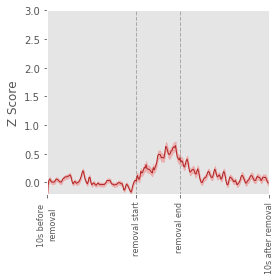

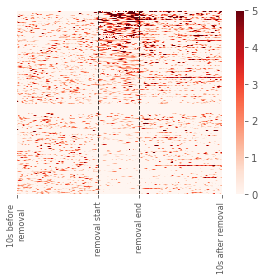

In [57]:

[fig, mean, sem] = plot_populationtimewarp_end(timewarpresults)
plt.show()
#fig.savefig(savepath+'afterBLAnoresponses_graph2.png', dpi = 300)
fig1 = plot_sorted_timewarp_end(timewarpresults, 0, 5, 'Reds')
#plt.show()
plt.rcParams['svg.fonttype'] = 'none'
fig1.savefig('F:/Figure3/removalheatmap.svg', format = 'svg', dpi = 500, transparent = True)
#fig1.savefig(savepath+'afterBLAnoresponses_graph.png', dpi = 300)

#np.savetxt(savepath+'afterBLAnoresponses_graph3values.csv', np.vstack((mean, sem)), delimiter = ',', fmt = '%s')
#np.savetxt(savepath+'afterBLAnoresponses_rawvalues.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [10]:
def plot_populationtimewarp_end(timewarpresults):
    
    timewarpresults[np.isinf(timewarpresults)] = 0
    timewarpresults[np.isnan(timewarpresults)] = 0
    
    timewarpresults[timewarpresults > 20] = 20

    plt.close()
    fig, ax = plt.subplots(1, figsize = (4, 4))

    timewarpmean = np.mean(timewarpresults[1:, :-1], axis = 0)
    timewarpsem = stats.sem(timewarpresults[1:, :-1], axis = 0)

    ax.fill_between(np.arange(0, len(timewarpmean)), timewarpmean+timewarpsem, timewarpmean-timewarpsem, color = 'lightcoral', alpha = 0.5)
    ax.plot(timewarpmean, color = 'firebrick', lw = 1)

    ax.grid(False)
    ax.set_ylabel('Z Score')
    ax.vlines(100, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.vlines(149, -.5, 3, linestyle = '--', color = 'darkgrey', lw = 1)
    ax.set_xticks((0, 100, 149, 249))
    ax.set_xticklabels(('10s before \nremoval', 'removal start', 'removal end','10s after removal'), 
            rotation = 90, fontsize = 8)
    ax.set_ylim(-.2,3)
    ax.set_xlim(0, 249)
    plt.tight_layout()
    return(fig, timewarpmean, timewarpsem)

In [53]:
def plot_sorted_timewarp_end(timewarp, vmin, vmax, color):
    sortorder = np.reshape(np.argsort(np.mean(timewarp[:,100:150], axis = 1)), (len(timewarp), 1))

    timewarp_sorted = np.take_along_axis(timewarp, sortorder, axis = 0)
    
    plt.close()
    
    fig, ax = plt.subplots(1, figsize = (4, 4))
    a = ax.imshow(timewarp_sorted, vmin = vmin, vmax = vmax, cmap = color, aspect = 'auto')
    ax.set_ylim(0, len(timewarp_sorted))
    ax.vlines(99, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)
    ax.vlines(149, ymin = 0, ymax = len(timewarp_sorted), linestyle = '--', color = 'black', alpha = 0.75, lw = 1)    
    ax.set_xticks((0, 99, 149, 249))
    ax.set_xticklabels(('10s before \nremoval', 'removal start', 'removal end','10s after removal'), rotation = 90, fontsize = 8)
    plt.colorbar(a)
    ax.grid(False)
    ax.set_yticks([])
    plt.tight_layout()
    return(fig)

In [ ]:
func_format.foldercheck(savepath)

fig1 = plot_sorted_timewarp(timewarpresults, 0, 7, 'Reds')
fig1.savefig(savepath+'passiveBLAall_graph2.png', dpi = 300)
[fig2, meantrace, semtrace] = plot_populationtimewarp(timewarpresults)
fig2.savefig(savepath+'passiveBLAall_graph3.png', dpi = 300)
[heatmap_masked, sortorder] = order_pad_mask(zscoreresults)
fig3 = plot_heatmap_rawvalues(heatmap_masked, 'Reds', 0, 7)
fig3.savefig(savepath+'passiveBLAall_graph1.png', dpi = 300)

np.savetxt(savepath+'passiveBLAall_graph3values.csv', np.vstack((meantrace, semtrace)), delimiter = ',', fmt = '%s')
np.savetxt(savepath+'passiveBLAall_rawvalues.csv', rawvaluesave, delimiter = ',', fmt = '%s')

In [ ]:
interactionfile = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

date = ['13042019', '01102019', '27062020', '06072020']
interactionfile = interactionfile[np.isin(interactionfile[:,1], date)]

neuronresponse = np.loadtxt('F:/ResponseType_BLAday1_4rats/responseprofile.csv', delimiter = ',', dtype = str)

In [ ]:
savepath = 'F:/PopulationAuROC/'
func_format.foldercheck(savepath)

for i, row in enumerate(interactionfile):
    ratID = row[0]
    date = row[1]
    intnum = row[2]
    
    sync = np.loadtxt('F:/'+ratID+'/Electrophys/'+date+'/Sync/'+intnum+'_frameSync.csv', delimiter = ',', dtype = float)
    presentationstart = sync[np.int(row[3])]
    presentation = sync[np.int(row[4])]
    presentationstop = sync[np.int(row[5])]
    contactstart = sync[np.int(row[7])]
    removal =sync[np.int(row[9])]
    
    if row[6] != 'nan':
        approachstart = sync[np.int(row[6])]
    if row[8] != 'nan':
        removalstart = sync[np.int(row[8])]
    if row[10] != 'nan':
        removalstop = sync[np.int(row[10])]
        
    inttimebins = np.arange(presentationstart-10, removal+300, .1)
    
    neuronlist = neuronresponse[neuronresponse[:,0] == ratID]
    neuronlist = neuronlist[neuronlist[:,1] == date]
    for n, neuron in enumerate(neuronlist):
        
        singleunit_auROC = []
        spikes = np.array(np.ravel(np.load('F:/'+ratID+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'+neuron[2]+'.npy'))/1000, np.float)
        
        intspikes = func_analysis.extractSpikes(spikes, presentationstart-300, removal+300)
        fr = func_analysis.firingrate(intspikes, .1, presentationstart-300, removal+300, smooth=False)
        
        meanfr = np.nanmean(fr)
        stdfr = np.nanstd(fr)
        
        zfr = (fr - meanfr) / stdfr
        
        if n == 0:
            population_zscore = zfr
            populationid = neuron[:5]
        else:
            population_zscore = np.vstack((population_zscore, zfr))
            populationid = np.vstack((populationid, neuron[:5]))
            
    np.savetxt(savepath+ratID+'_'+date+'_'+intnum+'.csv', population_zscore, delimiter = ',')
    np.savetxt(savepath+ratID+'_'+date+'_'+intnum+'id.csv', populationid, delimiter = ',', fmt = '%s')
    print(ratID + ' '+ date + ' ' + intnum + ' completed...')
    

In [ ]:
singleunit_auROC

In [ ]:
func_analysis.calcROC(baselinefr, test)

In [ ]:
time+1

In [ ]:
test = np.histogram(intspikes, bins = np.arange(time, time+1.01))[0]

In [ ]:
np.arange(time, time+1)